<p align="center">
    <a href="https://predict-idlab.github.io/landmarker">
        <img alt="landmarker" src="https://raw.githubusercontent.com/predict-idlab/landmarker/main/docs/_static/images/logo.svg" width="66%">
    </a>
</p>

# OAI pelvis X-ray Dataset

We will go through the following steps:
* [Loading the dataset](#Loading-the-dataset)
* [Constructing a heatmap generator](#Constructing-a-heatmap-generator)
* [Inspecting the dataset](#Inspecting-the-dataset)
* [Training and initializing the SpatialConfiguration model](#Training-the-model)
* [Evaluating the model](#Evaluating-the-model)

<a target="_blank" href="https://colab.research.google.com/github/predict-idlab/landmarker/examples/adaptive_scn_isbi2015.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup environment

In [1]:
# !python -c "import landmarker" || pip install landmarker

import sys
import os

sys.path.append("../src/")
import landmarker

## Setup imports and variables

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from monai.transforms import (Compose, RandAffined, RandGaussianNoised, RandStdShiftIntensityd,
                              RandScaleIntensityd, RandAdjustContrastd, RandHistogramShiftd,
                              ScaleIntensityd, Lambdad)
from tqdm.notebook import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the dataset

In [4]:
from landmarker.transforms.images import UseOnlyFirstChannel
fn_keys = ('image',)
spatial_transformd = [RandAffined(fn_keys, prob=1,
                        rotate_range=(-np.pi/12, np.pi/12),
                        translate_range=(-10, 10),
                        scale_range=(-0.1, 0.1),
                        shear_range=(-0.1, 0.1)
                        )]

train_transformd = Compose([
                            UseOnlyFirstChannel(('image', )),
                            RandGaussianNoised(('image', ), prob=0.2, mean=0, std=0.1),  # Add gaussian noise
                            RandScaleIntensityd(('image', ), factors=0.25, prob=0.2),  # Add random intensity scaling
                            RandAdjustContrastd(('image', ), prob=0.2, gamma=(0.5,4.5)),  # Randomly adjust contrast
                            RandHistogramShiftd(('image', ), prob=0.2),  # Randomly shift histogram
                            ScaleIntensityd(('image', )),  # Scale intensity
                        ] + spatial_transformd)

inference_transformd = Compose([
    UseOnlyFirstChannel(('image', )),
    ScaleIntensityd(('image', )),
])

In [5]:
from glob import glob
import pandas as pd

data_dir = "../../data/OAIPelvis/"

df_coord_info = pd.read_excel(data_dir+"Coordinates_information.xlsx")
df_info = pd.read_excel(data_dir+"original_information.xlsx")
df_info["new_image_file"] = df_info["image_file"].str.replace("s3://NDAR_Central_4/submission_13411/48m/", data_dir).str.replace(".tar.gz", "/001.dcm")
df_info["png_path"] = data_dir + "images/"  + df_info["new_image_file"].str.split("/").apply(lambda x: x[-2]) + ".png"
df_info["image_name"] = df_info["new_image_file"].str.split("/").apply(lambda x: x[-2]) + "_1x1"
df_info = df_info.merge(df_coord_info, on="image_name")

In [6]:
image_paths = df_info["png_path"]
pixel_spacing = df_info[["image_resolution1", "image_resolution2"]].to_numpy()

landmark_cols = df_coord_info.drop(columns=["image_name"]).columns
landmarks = np.flip(df_info[landmark_cols].to_numpy().reshape(-1, 8, 2).astype(float)*4,-1)

In [7]:
list_idxs = np.arange(len(image_paths))
np.random.seed(1817)
np.random.shuffle(list_idxs)

In [8]:
from landmarker.data import LandmarkDataset
fold_size = 105

image_paths_folds = []
pixel_spacing_folds = []
landmarks_folds = []
ds_folds = []
for i in range(5):
    if i == 4:
        fold_idxs = list_idxs[i*fold_size:]
    else:
        fold_idxs = list_idxs[i*fold_size:(i+1)*fold_size]
    image_paths_folds.append(image_paths[fold_idxs].to_list())
    pixel_spacing_folds.append(pixel_spacing[fold_idxs])
    landmarks_folds.append(landmarks[fold_idxs])
    ds_folds.append(
        LandmarkDataset(
            imgs = image_paths_folds[i],
            landmarks = landmarks_folds[i],
            transform = inference_transformd,
            dim_img = (512, 512),
            pixel_spacing = pixel_spacing_folds[i],
            store_imgs = True
        )
    )

Reading 105 images...


100%|██████████| 105/105 [00:43<00:00,  2.40it/s]


Resizing 105 images and landmarks...


100%|██████████| 105/105 [00:04<00:00, 26.09it/s]


Reading 105 images...


100%|██████████| 105/105 [00:38<00:00,  2.70it/s]


Resizing 105 images and landmarks...


100%|██████████| 105/105 [00:04<00:00, 21.40it/s]


Reading 105 images...


100%|██████████| 105/105 [00:39<00:00,  2.63it/s]


Resizing 105 images and landmarks...


100%|██████████| 105/105 [00:06<00:00, 15.83it/s]


Reading 105 images...


100%|██████████| 105/105 [00:38<00:00,  2.71it/s]


Resizing 105 images and landmarks...


100%|██████████| 105/105 [00:05<00:00, 19.63it/s]


Reading 104 images...


100%|██████████| 104/104 [00:36<00:00,  2.85it/s]


Resizing 104 images and landmarks...


100%|██████████| 104/104 [00:04<00:00, 21.35it/s]


## Constructing a heatmap generator

**Note that with 2D landmarks the y coordinates are the first dimension, and the x coordinates are the
second dimension.**

In [9]:
from landmarker.heatmap.generator import GaussianHeatmapGenerator

heatmap_generators_folds = []

for _ in range(5):
    heatmap_generators_folds.append(GaussianHeatmapGenerator(
        nb_landmarks=8,
        sigmas=3,
        gamma=100,
        heatmap_size=(512, 512),
        learnable=True, # If True, the heatmap generator will be trainable
    ))

## Inspecting the dataset

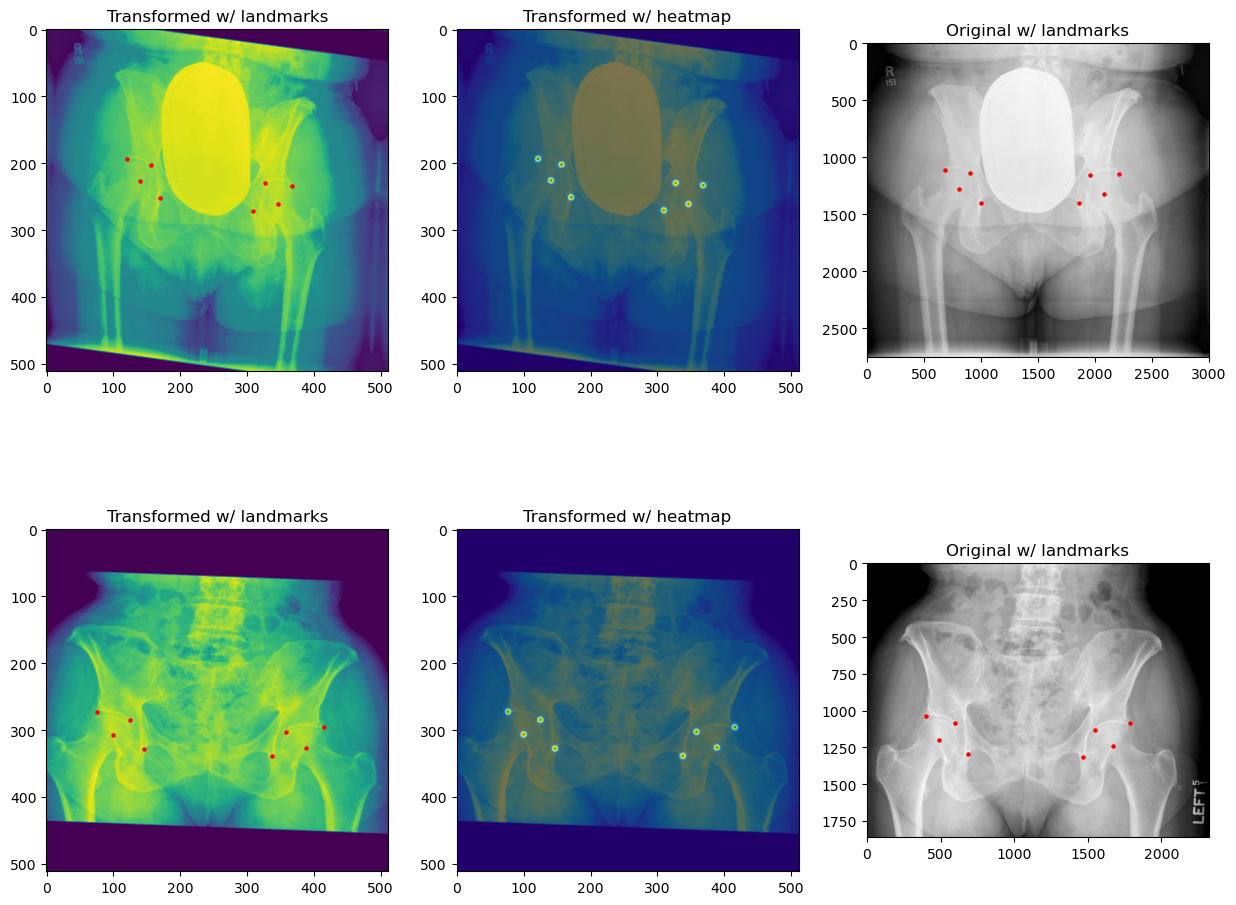

In [10]:
from landmarker.visualize import inspection_plot

ds_folds[0].transform = train_transformd
# Plot the first 3 images from the training set
inspection_plot(ds_folds[0], range(2), heatmap_generator=heatmap_generators_folds[0])
ds_folds[0].transform = inference_transformd

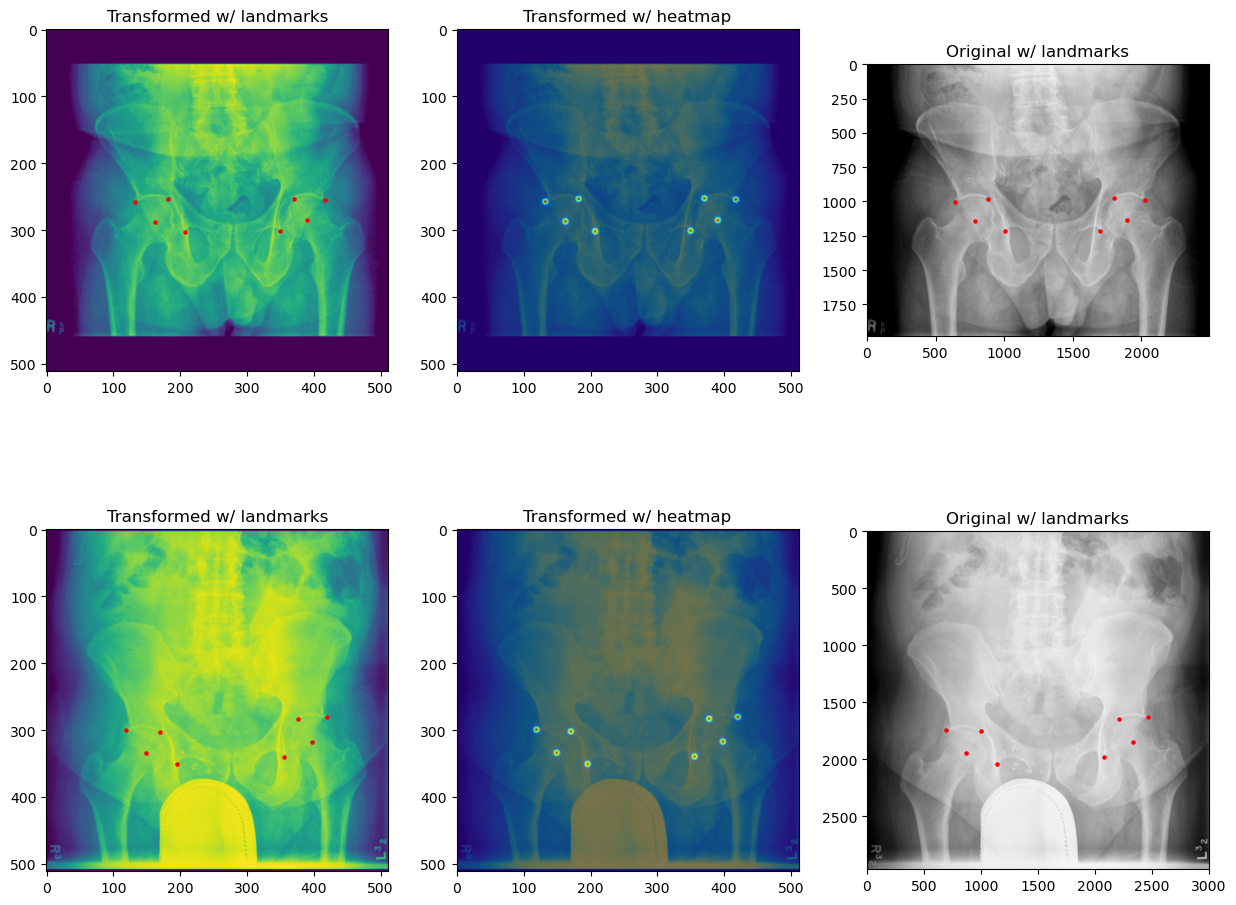

In [11]:
from landmarker.visualize import inspection_plot

# Plot the first 3 images from the training set
inspection_plot(ds_folds[2], range(2), heatmap_generator=heatmap_generators_folds[2])

## Training and initializing the SpatialConfiguration model

### Initializing the model, optimizer and loss function

In [12]:
from landmarker.models.spatial_configuration_net import OriginalSpatialConfigurationNet
from landmarker.losses import GaussianHeatmapL2Loss

criterion = GaussianHeatmapL2Loss(
    alpha=5
)

model_folds = []
lr = 1e-6
batch_size = 1
epochs = 200

for _ in range(5):
    model_folds.append(OriginalSpatialConfigurationNet(in_channels=1, out_channels=8).to(device))

### Training the model

In [13]:
from landmarker.heatmap.decoder import heatmap_to_coord
from landmarker.metrics import point_error

def train_epoch(model, heatmap_generator, train_loader, criterion, optimizer, device):
    running_loss = 0
    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        images = batch["image"].to(device)
        heatmaps = heatmap_generator(batch["landmark"]).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, heatmap_generator.sigmas, heatmaps)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10000.0)
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def val_epoch(model, heatmap_generator, val_loader, criterion, device, method="local_soft_argmax"):
    eval_loss = 0
    eval_mpe = 0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_loader)):
            images = batch["image"].to(device)
            landmarks = batch["landmark"].to(device)
            outputs = model(images)
            dim_orig = batch["dim_original"].to(device)
            pixel_spacing = batch["spacing"].to(device)
            padding = batch["padding"].to(device)
            heatmaps = heatmap_generator(batch["landmark"]).to(device)
            loss = criterion(outputs, heatmap_generator.sigmas, heatmaps)
            pred_landmarks = heatmap_to_coord(outputs, method=method)
            eval_loss += loss.item()
            eval_mpe += point_error(landmarks, pred_landmarks, images.shape[-2:], dim_orig,
                                    pixel_spacing, padding, reduction="mean")
    return eval_loss / len(val_loader), eval_mpe / len(val_loader)

def train(model, heatmap_generator, train_loader, val_loader, criterion, optimizer, device, epochs=1000):
    for epoch in tqdm(range(epochs)):
        train_loss = train_epoch(model, heatmap_generator, train_loader, criterion, optimizer, device)
        val_loss, val_mpe = val_epoch(model, heatmap_generator, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val mpe: {val_mpe:.4f}")
        lr_scheduler.step(val_loss)

In [ ]:
for i, model in enumerate(model_folds):
    print("="*50)
    print(f"Fitting model with hold-out fold {i}")
    print("="*50)
    ds_val = ds_folds[i]
    ds_val.transform = inference_transformd
    ds_train = []
    for i_train in range(5):
        if i == i_train:
            continue
        ds_folds[i_train].transform = train_transformd
        ds_train.append(ds_folds[i_train])
    ds_train = torch.utils.data.ConcatDataset(ds_train)
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=4)
    optimizer = torch.optim.SGD([
        {'params': model.parameters(), "weight_decay":1e-3},
        {'params': heatmap_generators_folds[i].sigmas},
        {'params': heatmap_generators_folds[i].rotation}]
        , lr=lr, momentum=0.99, nesterov=True)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                              patience=10, verbose=True, cooldown=10)
    train(model, heatmap_generators_folds[i], train_loader, val_loader, criterion, optimizer, device,
          epochs=epochs)

## Evaluating the model

In [14]:
for i, model in enumerate(model_folds):
    model.load_state_dict(torch.load(f"oai-pelvis-scn-fold{i}.pt", weights_only=True))
    heatmap_generators_folds[i].load_state_dict(torch.load(f"oai-pelvis-scn-heatmap-generator-fold{i}.pt", weights_only=True))

In [15]:
pred_landmarks_folds = []
true_landmarks_folds = []
dim_origs_folds = []
pixel_spacings_folds = []
paddings_folds = []
test_mpe = 0

for i, model in enumerate(model_folds):
    pred_landmarks = []
    true_landmarks = []
    dim_origs = []
    pixel_spacings = []
    paddings = []
    model.eval()
    ds_test = ds_folds[i]
    ds_test.transform = inference_transformd
    test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=4)
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader)):
            images = batch["image"].to(device)
            outputs = model(images)
            dim_orig = batch["dim_original"].to(device)
            pixel_spacing = batch["spacing"].to(device)
            padding = batch["padding"].to(device)
            landmarks = batch["landmark"].to(device)
            pred_landmark = heatmap_to_coord(outputs, method="local_soft_argmax")
            test_mpe += point_error(landmarks, pred_landmark, images.shape[-2:], dim_orig,
                                    pixel_spacing, padding, reduction="mean")
            pred_landmarks.append(pred_landmark.cpu())
            true_landmarks.append(landmarks.cpu())
            dim_origs.append(dim_orig.cpu())
            pixel_spacings.append(pixel_spacing.cpu())
            paddings.append(padding.cpu())
    
    pred_landmarks = torch.cat(pred_landmarks)
    true_landmarks = torch.cat(true_landmarks)
    dim_origs = torch.cat(dim_origs)
    pixel_spacings = torch.cat(pixel_spacings)
    paddings = torch.cat(paddings)

    pred_landmarks_folds.append(pred_landmarks)
    true_landmarks_folds.append(true_landmarks)
    dim_origs_folds.append(dim_origs)
    pixel_spacings_folds.append(pixel_spacings)
    paddings_folds.append(paddings)

pred_landmarks = torch.cat(pred_landmarks_folds)
true_landmarks = torch.cat(true_landmarks_folds)
dim_origs = torch.cat(dim_origs_folds)
pixel_spacings = torch.cat(pixel_spacings_folds)
paddings = torch.cat(paddings_folds)


test_mpe /= len(df_coord_info)

print(f"Test Mean PE: {test_mpe:.4f}")

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Test Mean PE: 1.6135


In [20]:
from landmarker.metrics import sdr

sdr_test = sdr([1.0, 2.0, 3.0, 4.0], true_landmarks=true_landmarks, pred_landmarks=pred_landmarks,
               dim=(512, 512), dim_orig=dim_origs.int(), pixel_spacing=pixel_spacings, padding=paddings)
for key in sdr_test:
    print(f"SDR for {key}mm: {sdr_test[key]:.4f}")

SDR for 1.0mm: 33.2538
SDR for 2.0mm: 74.3798
SDR for 3.0mm: 90.9590
SDR for 4.0mm: 95.8492


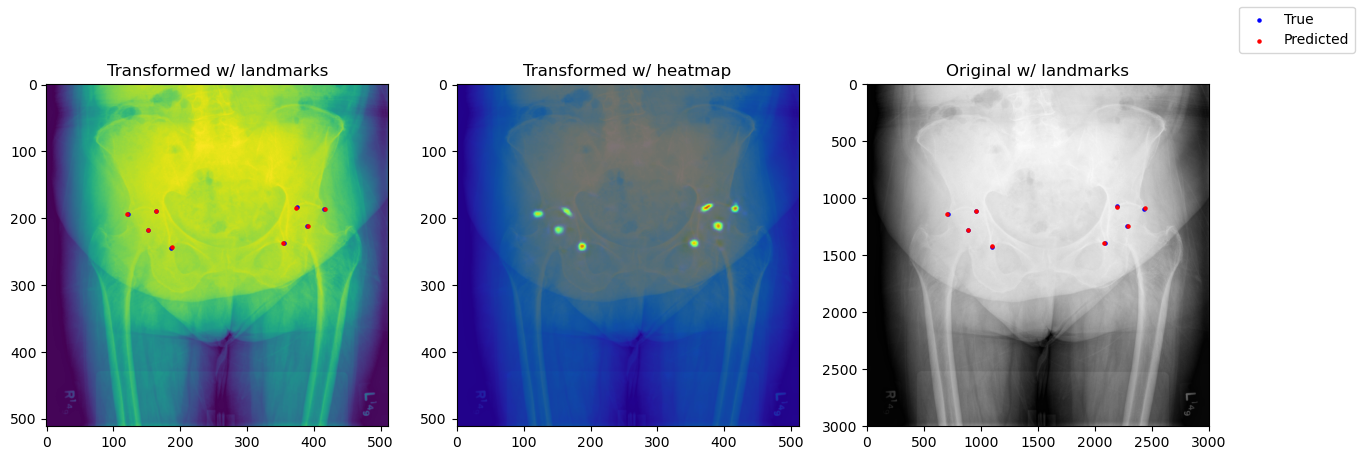

In [21]:
from landmarker.visualize.utils import prediction_inspect_plot

model_folds[0].eval()
model_folds[0].to("cpu")
prediction_inspect_plot(ds_folds[0], model_folds[0], 5, save_path="pred_inspect_plot_pelvis.pdf")

In [22]:
from landmarker.visualize import detection_report

detection_report(true_landmarks, pred_landmarks, dim=(512, 512), dim_orig=dim_origs.int(),
                    pixel_spacing=pixel_spacings, padding=paddings, class_names=ds_folds[0].class_names,
                    radius=[1.0, 2.0, 3.0, 4.0], digits=2)

Detection report:
1# Point-to-point error (PE) statistics:
Class               Mean      Median    Std       Min       Max       
----------------------------------------------------------------------
landmark_0          1.51      1.39      0.88      0.04      4.72      
landmark_1          1.55      1.42      0.89      0.06      7.26      
landmark_2          1.20      1.06      0.83      0.04      7.61      
landmark_3          2.15      1.73      1.69      0.06      12.86     
landmark_4          1.80      1.43      1.57      0.05      18.28     
landmark_5          1.17      1.07      0.75      0.04      8.24      
landmark_6          1.82      1.56      1.27      0.09      10.12     
landmark_7          1.70      1.35      1.36      0.12      12.76     

2# Success detection rate (SDR):
Class               SDR (PE≤1.0mm) SDR (PE≤2.0mm) SDR (PE≤3.0mm) SDR (PE≤4.0mm) 
--------------------------------------------------------------------------------
landmark_0          33.36          

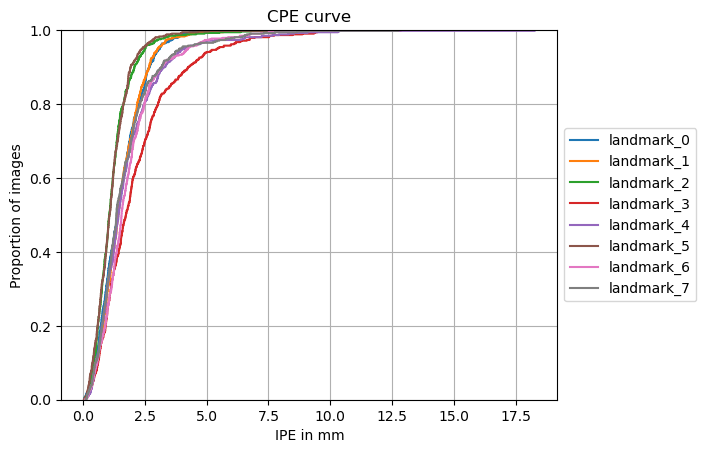

In [19]:
from landmarker.visualize import plot_cpe

plot_cpe(true_landmarks, pred_landmarks, dim=(512, 512), dim_orig=dim_origs.int(),
                    pixel_spacing=pixel_spacings, padding=paddings, class_names=ds_folds[0].class_names,
                    group=False, title="CPE curve", save_path=None,
                    stat='proportion', unit='mm', kind='ecdf')